In [1]:
import itertools
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from fbprophet import Prophet

#warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('fivethirtyeight')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
matplotlib.rcParams['figure.figsize'] = 10, 8

/usr/local/Cellar/python/3.6.5_1/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
DATA_DIR = '.'
df = pd.read_excel(DATA_DIR + '/Superstore.xls')
df.head()

,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Postal Code,Region,Product ID,Category,Sub-Category,Product Name,Sales,Quantity,Discount,Profit
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-BO-10001798,Furniture,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,42420,South,FUR-CH-10000454,Furniture,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,90036,West,OFF-LA-10000240,Office Supplies,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,FUR-TA-10000577,Furniture,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,33311,South,OFF-ST-10000760,Office Supplies,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164


In [3]:
furniture = df.loc[df.Category == 'Furniture']

In [4]:
furniture['Order Date'].min(), furniture['Order Date'].max()

(Timestamp('2014-01-06 00:00:00'), Timestamp('2017-12-30 00:00:00'))

# Data Prep

In [5]:
drops = [
    'Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
    'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code', 
    'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name', 
    'Quantity', 'Discount', 'Profit']
furniture.drop(drops, axis=1, inplace=True)
furniture = furniture.sort_values('Order Date')
print(furniture.isnull().sum())
furniture.head()

Order Date    0
Sales         0
dtype: int64


/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Order Date,Sales
7474,2014-01-06,2573.820
7660,2014-01-07,76.728
866,2014-01-10,51.940
716,2014-01-11,9.940
2978,2014-01-13,545.940


In [6]:
furniture = furniture.set_index('Order Date')
furniture.head()

,Sales
Order Date,
2014-01-06,2573.820
2014-01-07,76.728
2014-01-10,51.940
2014-01-11,9.940
2014-01-13,545.940


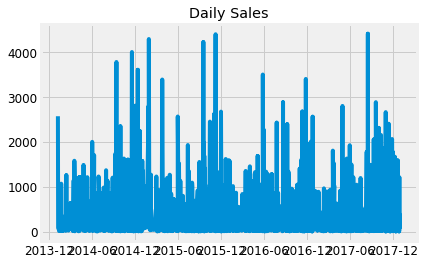

In [7]:
plt.plot(furniture['Sales']);
plt.title('Daily Sales');

In [8]:
# Aggregate to monthly means
y = furniture['Sales'].resample('MS').mean()
y[:10]

Order Date
2014-01-01    312.126250
2014-02-01    262.808286
2014-03-01    441.635030
2014-04-01    305.570654
2014-05-01    288.032792
2014-06-01    440.204187
2014-07-01    327.910636
2014-08-01    305.014437
2014-09-01    425.294300
2014-10-01    384.507719
Freq: MS, Name: Sales, dtype: float64

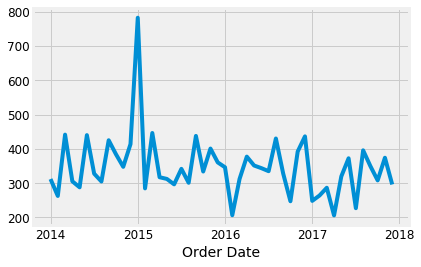

In [9]:
y.plot();

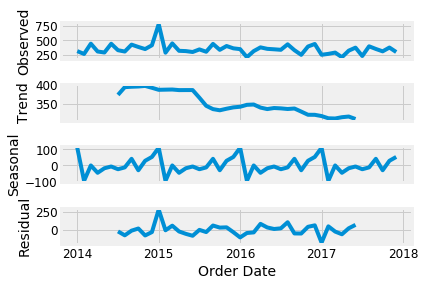

In [10]:
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig = decomposition.plot()

# ARIMA

In [11]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q)) # all combinations of p, d, q
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in pdq]

In [12]:
print('Example param combinations for Seasonal ARIMA:')
print('SARIMA X: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMA X: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Example param combinations for Seasonal ARIMA:
SARIMA X: (0, 0, 1) x (0, 0, 1, 12)
SARIMA X: (0, 1, 0) x (1, 0, 0, 12)


In [13]:
min_AIC = np.inf
best_params = [None, None]
best_results = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, 
                                            order=param, 
                                            seasonal_order=param_seasonal,
                                            enforce_stationary=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            if results.aic < min_AIC:
                min_AIC = results.aic
                best_params = [param, param_seasonal]
                best_results = results
            #print('ARIMA{}x{}12\tAIC: {}'.format(
            #    param, param_seasonal, results.aic))
        except:
            continue

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1052: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if not params_seasonal_variance == []:
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:508: Co

In [14]:
print(min_AIC)
print(best_params)
print(best_results)

442.6081132147832
[(0, 1, 1), (1, 1, 0, 12)]


# Fitting ARIMA model

In [15]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(0, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary().tables[1])

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.0000      0.419     -2.387      0.017      -1.821      -0.179
ar.S.L12       0.0086      0.010      0.856      0.392      -0.011       0.028
sigma2      6235.1881   6.72e-05   9.28e+07      0.000    6235.188    6235.188


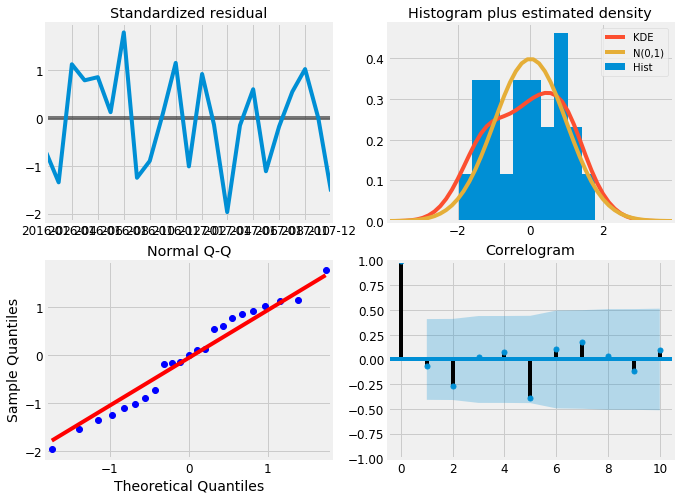

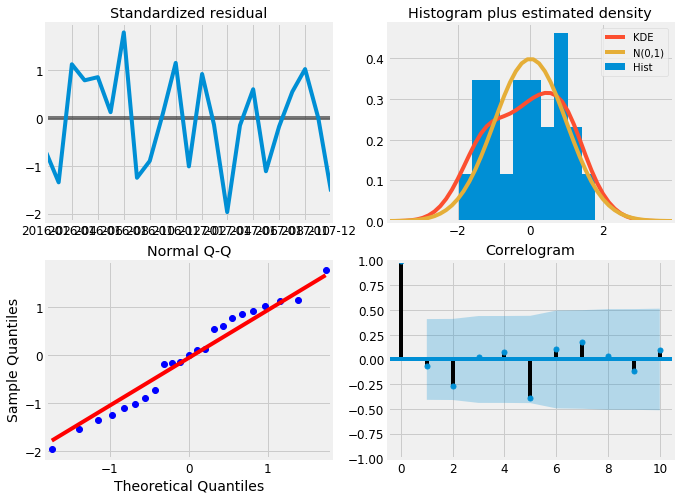

In [16]:
results.plot_diagnostics(figsize=(10, 8))

# Validating Forecasts

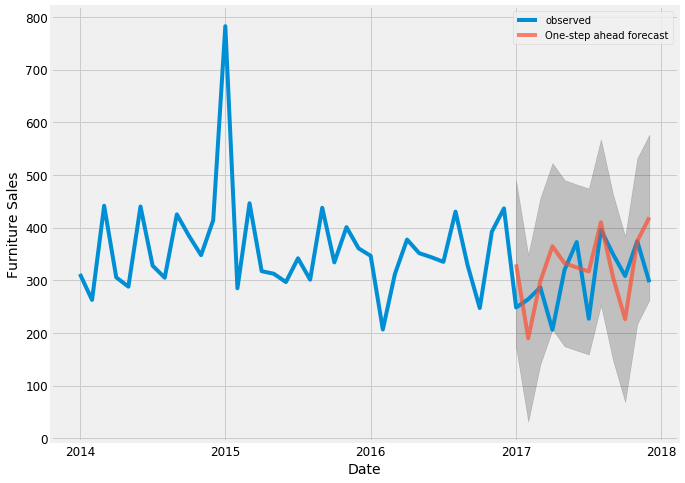

In [17]:
pred = results.get_prediction(start=pd.to_datetime('2017-01-01'), 
                              dynamic=False)
pred_ci = pred.conf_int()

ax = y['2014':].plot(label='observed')
pred.predicted_mean.plot(
    ax=ax, label='One-step ahead forecast', alpha=0.7, figsize=(10, 8));
ax.fill_between(pred_ci.index, 
                pred_ci.iloc[:, 0], 
                pred_ci.iloc[:, 1], 
                color='k', 
                alpha=0.2);
ax.set_xlabel('Date');
ax.set_ylabel('Furniture Sales');
plt.legend();

In [18]:
y_forecasted = pred.predicted_mean
y_actual = y['2017-01-01':]
mse = ((y_forecasted - y_actual) ** 2).mean()
print('MSE:', round(mse, 2))
print('RMSE:', round(np.sqrt(mse), 2))

MSE: 6005.96
RMSE: 77.5


# Visualizing Forecasts

In [19]:
pred_uc = results.get_forecast(steps=100)
pred_ci = pred_uc.conf_int(0.95)

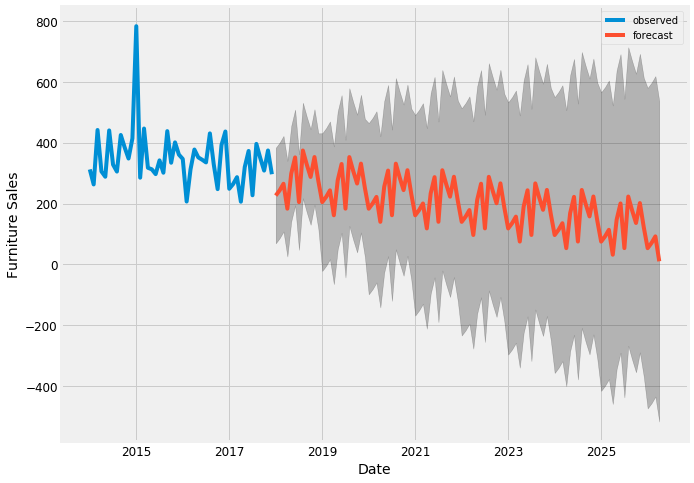

In [20]:
ax = y.plot(label='observed', figsize=[10, 8]);
pred_uc.predicted_mean.plot(ax=ax, label='forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], 
                color='k',
                alpha=0.25);
ax.set_xlabel('Date');
ax.set_ylabel('Furniture Sales');
plt.legend();

# Furniture vs. Office Supplies

In [21]:
furniture = df.loc[df['Category'] == 'Furniture']
office    = df.loc[df['Category'] == 'Office Supplies']
furniture.shape, office.shape

((2121, 21), (6026, 21))

# Exploration

In [22]:
cols = [
    'Row ID', 'Order ID', 'Ship Date', 'Ship Mode', 'Customer ID', 
    'Customer Name', 'Segment', 'Country', 'City', 'State', 'Postal Code',
    'Region', 'Product ID', 'Category', 'Sub-Category', 'Product Name',
    'Quantity', 'Discount', 'Profit']
furniture.drop(cols, axis=1, inplace=True)

furniture = furniture.sort_values('Order Date')
office = office.sort_values('Order Date')

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [23]:
furniture = furniture.groupby('Order Date')['Sales'].sum().reset_index()
office = office.groupby('Order Date')['Sales'].sum().reset_index()

In [24]:
furniture = furniture.set_index('Order Date')
office = office.set_index('Order Date')

In [25]:
y_furniture = furniture['Sales'].resample('MS').mean()
y_office = office['Sales'].resample('MS').mean()

In [26]:
furniture = pd.DataFrame({'Order Date': y_furniture.index, 
                          'Sales': y_furniture.values})
office = pd.DataFrame({'Order Date': y_office.index, 
                       'Sales': y_office.values})

In [27]:
store = furniture.merge(office, how='inner', on='Order Date')
store.rename(
    columns={'Sales_x': 'furniture_sales', 'Sales_y': 'office_sales'},
    inplace=True)
store.head()

,Order Date,furniture_sales,office_sales
0,2014-01-01,480.194231,285.357647
1,2014-02-01,367.931600,63.042588
2,2014-03-01,857.291529,391.176318
3,2014-04-01,567.488357,464.794750
4,2014-05-01,432.049188,324.346545


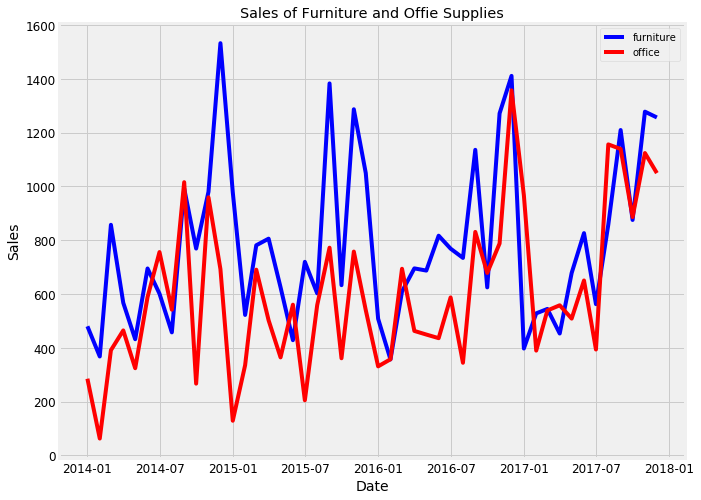

In [28]:
plt.figure(figsize=(10, 8));
plt.plot(
    store['Order Date'], store['furniture_sales'], 'b-', label='furniture');
plt.plot(
    store['Order Date'], store['office_sales'], 'r-', label='office');
plt.xlabel('Date');
plt.ylabel('Sales');
plt.title('Sales of Furniture and Offie Supplies');
plt.legend();

In [29]:
first_date = store.loc[
    np.min(list(
        np.where(store['office_sales'] > store['furniture_sales'])[0])), 
    'Order Date']
print('Office supplies first date outselling furniture: {}'.format(
    first_date.date()))

Office supplies first date outselling furniture: 2014-07-01


# Time Series Modeling with Prophet

In [30]:
furniture = furniture.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
furniture_model = Prophet(interval_width=0.95)
furniture_model.fit(furniture)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [31]:
office = office.rename(columns={'Order Date': 'ds', 'Sales': 'y'})
office_model = Prophet(interval_width=0.95)
office_model.fit(office)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/usr/local/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [32]:
furniture_forecast = furniture_model.make_future_dataframe(periods=36, 
                                                           freq='MS')
furniture_forecast = furniture_model.predict(furniture_forecast)

In [33]:
office_forecast = office_model.make_future_dataframe(periods=36, freq='MS')
office_forecast = office_model.predict(office_forecast)

<Figure size 720x576 with 0 Axes>

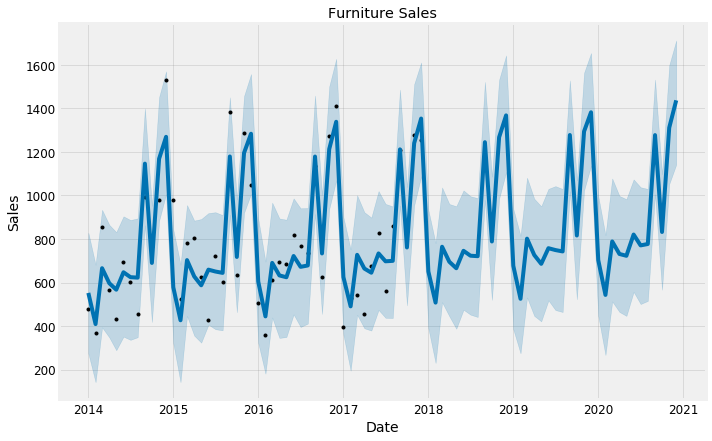

In [34]:
plt.figure(figsize=(10, 8));
furniture_model.plot(furniture_forecast, xlabel='Date', ylabel='Sales');
plt.title('Furniture Sales');

<Figure size 720x576 with 0 Axes>

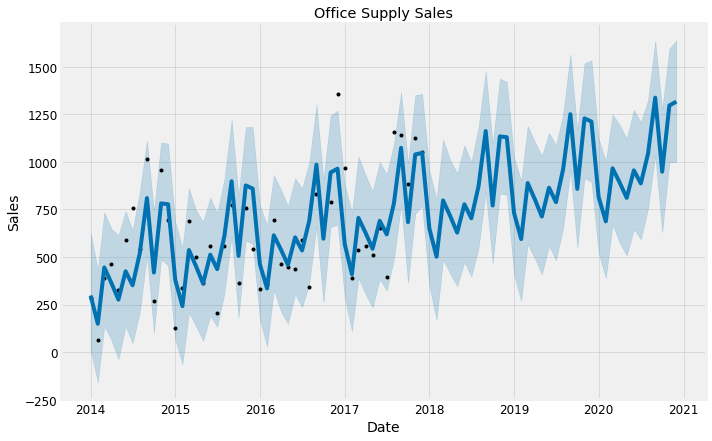

In [35]:
plt.figure(figsize=(10, 8));
office_model.plot(office_forecast, xlabel='Date', ylabel='Sales');
plt.title('Office Supply Sales');

# Compare Forecasts 

In [36]:
furniture_names = ['furniture_%s' % col 
                   for col in furniture_forecast.columns]
office_names = ['office_%s' % col for col in office_forecast.columns]

In [37]:
merge_furniture_forecast = furniture_forecast.copy()
merge_office_forecast = office_forecast.copy()

In [38]:
merge_furniture_forecast.columns = furniture_names
merge_office_forecast.columns = office_names

In [39]:
forecast = pd.merge(merge_furniture_forecast,
                    merge_office_forecast,
                    how='inner',
                    left_on='furniture_ds', 
                    right_on='office_ds')

In [40]:
forecast = forecast.rename(columns={'furniture_ds': 'Date'})\
                   .drop('office_ds', axis=1)
forecast.head()

,Date,furniture_trend,furniture_yhat_lower,furniture_yhat_upper,furniture_trend_lower,furniture_trend_upper,furniture_additive_terms,furniture_additive_terms_lower,furniture_additive_terms_upper,furniture_yearly,...,office_additive_terms,office_additive_terms_lower,office_additive_terms_upper,office_yearly,office_yearly_lower,office_yearly_upper,office_multiplicative_terms,office_multiplicative_terms_lower,office_multiplicative_terms_upper,office_yhat
0,2014-01-01,731.350832,274.562871,828.933218,731.350832,731.350832,-178.935009,-178.935009,-178.935009,-178.935009,...,-132.487041,-132.487041,-132.487041,-132.487041,-132.487041,-132.487041,0.0,0.0,0.0,297.861111
1,2014-02-01,733.442293,142.316128,682.036359,733.442293,733.442293,-324.072006,-324.072006,-324.072006,-324.072006,...,-288.224139,-288.224139,-288.224139,-288.224139,-288.224139,-288.224139,0.0,0.0,0.0,149.596082
2,2014-03-01,735.331355,394.378438,934.160317,735.331355,735.331355,-69.359319,-69.359319,-69.359319,-69.359319,...,0.847373,0.847373,0.847373,0.847373,0.847373,0.847373,0.0,0.0,0.0,445.416558
3,2014-04-01,737.422817,348.075415,864.927093,737.422817,737.422817,-140.383817,-140.383817,-140.383817,-140.383817,...,-89.140087,-89.140087,-89.140087,-89.140087,-89.140087,-89.140087,0.0,0.0,0.0,362.901168
4,2014-05-01,739.446812,289.286477,831.516558,739.446812,739.446812,-172.281896,-172.281896,-172.281896,-172.281896,...,-183.186206,-183.186206,-183.186206,-183.186206,-183.186206,-183.186206,0.0,0.0,0.0,276.086083


# Trend and Forecast Visualization

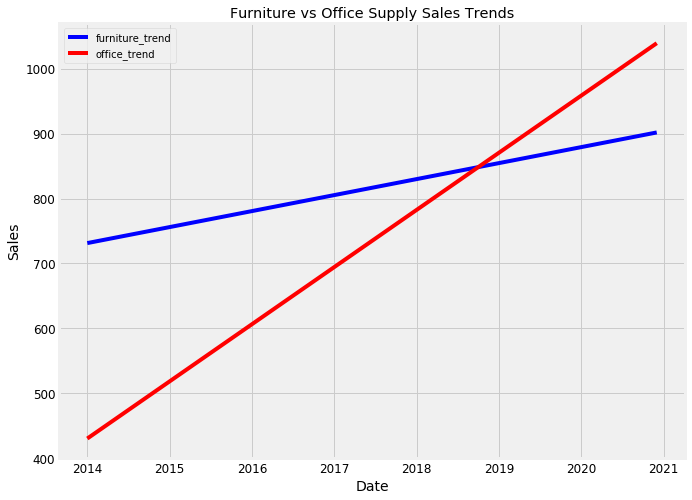

In [41]:
plt.figure(figsize=(10, 8));
plt.plot(forecast['Date'], forecast['furniture_trend'], 'b-');
plt.plot(forecast['Date'], forecast['office_trend'], 'r-');
plt.legend();
plt.xlabel('Date');
plt.ylabel('Sales');
plt.title('Furniture vs Office Supply Sales Trends');

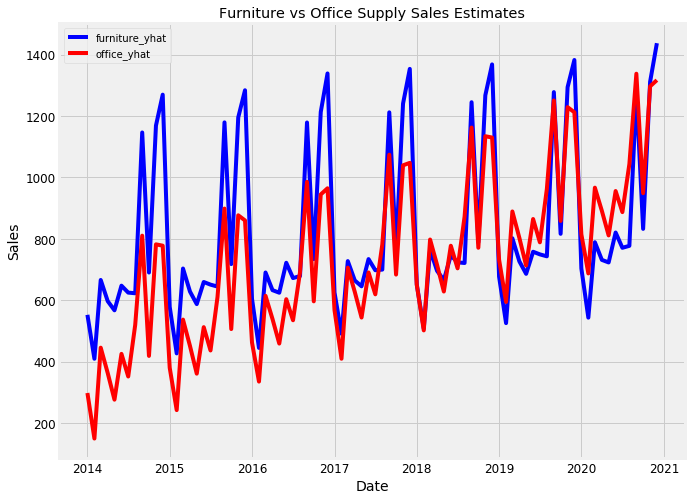

In [42]:
plt.figure(figsize=(10, 8));
plt.plot(forecast['Date'], forecast['furniture_yhat'], 'b-');
plt.plot(forecast['Date'], forecast['office_yhat'], 'r-');
plt.legend();
plt.xlabel('Date');
plt.ylabel('Sales');
plt.title('Furniture vs Office Supply Sales Estimates');

# Trends and Patterns

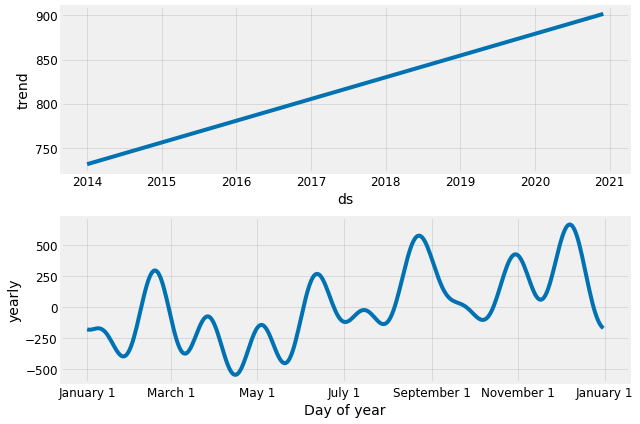

In [44]:
furniture_model.plot_components(furniture_forecast);

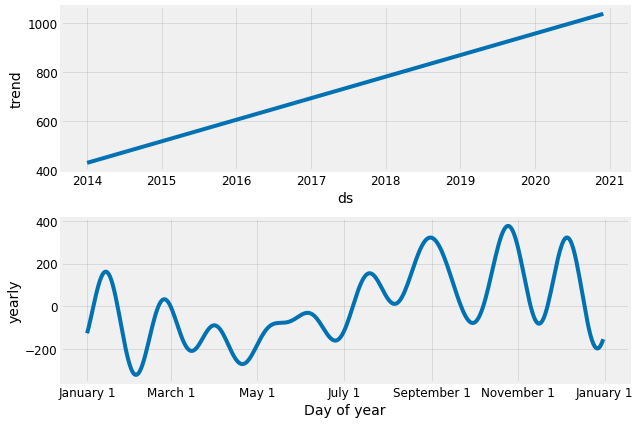

In [45]:
office_model.plot_components(office_forecast);